# Divergence, curl module and other field vector field parameters

This document present some examples of vector field processing using pygsf methods.

## Preliminary settings

In order to plot fields, we run the following commands:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

The modules to import for dealing with grids are:

In [3]:
from pygsf.mathematics.arrays import *
from pygsf.mathematics.geotransform import *
from pygsf.mathematics.mapping import *

## Fields and geotransform definitions

We calculate a theoretical, 2D vector field and check that the parameters calculated by *pygsf* is equal to the expected one.

We use a modified example from p. 67 in [1].

\begin{equation*}
 \vec{\mathbf{v}} = 0.0001 x y^3  \vec{\mathbf{i}} - 0.0002  x^2 y  \vec{\mathbf{j}} + 0  \vec{\mathbf{k}}
\end{equation*}



In order to create the two grids that represent the x- and the y-components, we therefore define the following two "transfer" functions from coordinates to z values: 

In [4]:
def z_func_fx(x, y):

    return 0.0001 * x * y**3

def z_func_fy(x, y):

    return - 0.0002 * x**2 * y

The above functions define the value of the cells, using the given x and y geographic coordinates.

Gridded field values are calculated for the theoretical source vector field x- and y- components using the provided number of rows and columns for the grid:

In [5]:
rows=200; cols=100

In [6]:
size_x = 0.25; size_y = 0.25

In [7]:
tlx = 15.0; tly = 30.0 

Arrays components are defined in terms of indices *i* and *j*, so to transform array indices to geographical coordinates we use a geotransform. The one chosen is:

In [8]:
gt1 = GeoTransform(
    inTopLeftX=tlx, 
    inTopLeftY=tly, 
    inPixWidth=size_x, 
    inPixHeight=size_y)

Note that the chosen geotransform has no axis rotation, as is in the most part of cases with geographic grids.

### vector field x-component

In [9]:
fx = array_from_function(
    row_num=rows, 
    col_num=cols, 
    geotransform=gt1, 
    z_transfer_func=z_func_fx)

### vector field y-component

In [10]:
fy = array_from_function(
    row_num=rows, 
    col_num=cols, 
    geotransform=gt1, 
    z_transfer_func=z_func_fy)

## Testing curl module

The definition of curl module in our 2D case is:

\begin{equation*}
\nabla \times \vec{\mathbf{v}} =  \begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial }{\partial x} &  \frac{\partial }{\partial y} & \frac{\partial }{\partial z} \\
{v_x} &  {v_y} & 0
\end{vmatrix}
\end{equation*}

so that the module of the curl is:

\begin{equation*}
 |curl| = \frac{\partial v_y}{\partial x} - \frac{\partial v_x}{\partial y}
\end{equation*}

### theoretical curl module

The vector function is:

\begin{equation*}
 \vec{\mathbf{v}} = 0.0001 x y^3  \vec{\mathbf{i}} - 0.0002  x^2 y  \vec{\mathbf{j}} + 0  \vec{\mathbf{k}}
\end{equation*}

therefore the theoretical curl module is:

\begin{equation*}
 curl = 0.0004 x y + 0.0003 x y^2
\end{equation*}

so that the theoretical transfer function is:

In [11]:
def z_func_curl_mod(x, y):
    
    return 0.0004 * x * y + 0.0003 * x * y**2

The theoretical divergence field can be created using the function expressing the analytical derivatives *z_func_div*:

In [12]:
theor_curl_mod = array_from_function(
    row_num=rows, 
    col_num=cols, 
    geotransform=gt1, 
    z_transfer_func=z_func_curl_mod)

In [13]:
print(theor_curl_mod)

[[ 4.2305334   4.30045957  4.37038574 ... 11.01337207 11.08329824
  11.15322441]
 [ 4.16152559  4.23031113  4.29909668 ... 10.83372363 10.90250918
  10.97129473]
 [ 4.09308496  4.16073926  4.22839355 ... 10.65555176 10.72320605
  10.79086035]
 ...
 [ 1.58611621  1.61233301  1.6385498  ...  4.12914551  4.1553623
   4.1815791 ]
 [ 1.62884434  1.65576738  1.68269043 ...  4.24037988  4.26730293
   4.29422598]
 [ 1.67213965  1.69977832  1.72741699 ...  4.35309082  4.38072949
   4.40836816]]


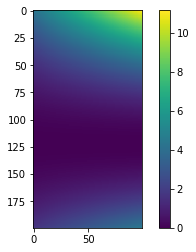

In [14]:
plt.imshow(theor_curl_mod); plt.colorbar()

### estimates of module of curl

In [15]:
def gradient_x(fld: 'array', cell_size_x: float) -> 'array':


    return np.gradient(fld, edge_order=1, axis=1) / cell_size_x

In [16]:
def gradient_y(fld: 'array', cell_size_y: float) -> 'array':


    return np.gradient(fld, edge_order=2, axis=0) / cell_size_y

In [17]:
"""
def slope(y, x):

    import numpy as np
    x_endpadded = np.zeros(np.size(x)+2, dtype=x.dtype.char)
    x_endpadded[0]    = x[0]
    x_endpadded[1:-1] = x 
    x_endpadded[-1]   = x[-1]

    y_endpadded = np.zeros(np.size(y)+2, dtype=y.dtype.char)
    y_endpadded[0]    = y[0]
    y_endpadded[1:-1] = y
    y_endpadded[-1]   = y[-1]

    y_im1 = y_endpadded[:-2]
    y_ip1 = y_endpadded[2:]
    x_im1 = x_endpadded[:-2]
    x_ip1 = x_endpadded[2:]

    return (y_ip1 - y_im1) / (x_ip1 - x_im1)

def curl(x, y, Fx, Fy):

    import numpy as np

    dFy_dx = np.zeros( (len(y), len(x)), dtype=np.float64 )
    dFx_dy = np.zeros( (len(y), len(x)), dtype=np.float64 )

    for iy in range(len(y)):
        dFy_dx[iy,:] = slope( np.ravel(Fy[iy,:]), x )

    for ix in range(len(x)):
        dFx_dy[:,ix] = slope( np.ravel(Fx[:,ix]), y )

    return dFx_dy - dFy_dx
"""

'\ndef slope(y, x):\n\n    import numpy as np\n    x_endpadded = np.zeros(np.size(x)+2, dtype=x.dtype.char)\n    x_endpadded[0]    = x[0]\n    x_endpadded[1:-1] = x \n    x_endpadded[-1]   = x[-1]\n\n    y_endpadded = np.zeros(np.size(y)+2, dtype=y.dtype.char)\n    y_endpadded[0]    = y[0]\n    y_endpadded[1:-1] = y\n    y_endpadded[-1]   = y[-1]\n\n    y_im1 = y_endpadded[:-2]\n    y_ip1 = y_endpadded[2:]\n    x_im1 = x_endpadded[:-2]\n    x_ip1 = x_endpadded[2:]\n\n    return (y_ip1 - y_im1) / (x_ip1 - x_im1)\n\ndef curl(x, y, Fx, Fy):\n\n    import numpy as np\n\n    dFy_dx = np.zeros( (len(y), len(x)), dtype=np.float64 )\n    dFx_dy = np.zeros( (len(y), len(x)), dtype=np.float64 )\n\n    for iy in range(len(y)):\n        dFy_dx[iy,:] = slope( np.ravel(Fy[iy,:]), x )\n\n    for ix in range(len(x)):\n        dFx_dy[:,ix] = slope( np.ravel(Fx[:,ix]), y )\n\n    return dFx_dy - dFy_dx\n'

In [18]:
def slope(y, x):

    x_endpadded = np.zeros(np.size(x)+2, dtype=x.dtype.char)
    x_endpadded[0]    = x[0]
    x_endpadded[1:-1] = x 
    x_endpadded[-1]   = x[-1]

    y_endpadded = np.zeros(np.size(y)+2, dtype=y.dtype.char)
    y_endpadded[0]    = y[0]
    y_endpadded[1:-1] = y
    y_endpadded[-1]   = y[-1]

    y_im1 = y_endpadded[:-2]
    y_ip1 = y_endpadded[2:]
    x_im1 = x_endpadded[:-2]
    x_ip1 = x_endpadded[2:]

    return (y_ip1 - y_im1) / (x_ip1 - x_im1)

In [19]:
def grad_indep_dx(x, y, Fy):
    """Curl of a vector F on a 2-D "rectangular" grid.
    """

    dFy_dx = np.zeros( (len(y), len(x)), dtype=np.float64 )

    for iy in range(len(y)):
        dFy_dx[iy,:] = slope( np.ravel(Fy[iy,:]), x )

    return dFy_dx

In [20]:
def grad_indep_dy(x, y, Fx):
    """Curl of a vector F on a 2-D "rectangular" grid.
    """

    dFx_dy = np.zeros( (len(y), len(x)), dtype=np.float64 )

    for ix in range(len(x)):
        dFx_dy[:,ix] = slope( np.ravel(Fx[:,ix]), y )

    return dFx_dy

In [21]:
x = np.arange(tlx + size_x / 2.0, tlx + cols*size_x, size_x)

In [22]:
y = np.arange(tly - size_y / 2.0, tly - rows*size_y, -size_y)

In [23]:
dFy_dx = grad_indep_dx(x, y, fy)

In [24]:
dFy_dx

array([[-0.1822375 , -0.18373125, -0.18671875, ..., -0.47053125,
        -0.47351875, -0.4750125 ],
       [-0.1807125 , -0.18219375, -0.18515625, ..., -0.46659375,
        -0.46955625, -0.4710375 ],
       [-0.1791875 , -0.18065625, -0.18359375, ..., -0.46265625,
        -0.46559375, -0.4670625 ],
       ...,
       [ 0.1181875 ,  0.11915625,  0.12109375, ...,  0.30515625,
         0.30709375,  0.3080625 ],
       [ 0.1197125 ,  0.12069375,  0.12265625, ...,  0.30909375,
         0.31105625,  0.3120375 ],
       [ 0.1212375 ,  0.12223125,  0.12421875, ...,  0.31303125,
         0.31501875,  0.3160125 ]])

In [25]:
gr_fy_x = gradient_x(fy, size_x)
print(gr_fy_x.dtype)

float64


In [26]:
print(gr_fy_x)

[[-0.1822375  -0.18373125 -0.18671875 ... -0.47053125 -0.47351875
  -0.4750125 ]
 [-0.1807125  -0.18219375 -0.18515625 ... -0.46659375 -0.46955625
  -0.4710375 ]
 [-0.1791875  -0.18065625 -0.18359375 ... -0.46265625 -0.46559375
  -0.4670625 ]
 ...
 [ 0.1181875   0.11915625  0.12109375 ...  0.30515625  0.30709375
   0.3080625 ]
 [ 0.1197125   0.12069375  0.12265625 ...  0.30909375  0.31105625
   0.3120375 ]
 [ 0.1212375   0.12223125  0.12421875 ...  0.31303125  0.31501875
   0.3160125 ]]


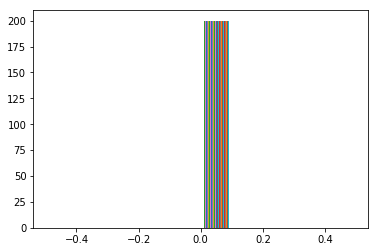

In [27]:
plt.hist(100*(gr_fy_x-dFy_dx)/dFy_dx); plt.show()

In [28]:
dFx_dy = grad_indep_dy(x, y, fx)

In [29]:
print(dFx_dy.shape);print(dFx_dy)

(200, 100)
[[ 4.01599473  4.0823748   4.14875488 ... 10.4548623  10.52124238
  10.58762246]
 [ 3.98238887  4.04821348  4.11403809 ... 10.36737598 10.43320059
  10.4990252 ]
 [ 3.91546074  3.9801791   4.04489746 ... 10.1931416  10.25785996
  10.32257832]
 ...
 [ 1.70342949  1.73158535  1.75974121 ...  4.43454785  4.46270371
   4.49085957]
 [ 1.74767012  1.77655723  1.80544434 ...  4.54971973  4.57860684
   4.60749395]
 [ 1.76993223  1.7991873   1.82844238 ...  4.6076748   4.63692988
   4.66618496]]


In [30]:
gr_fx_y = gradient_y(fx, size_y)
print(gr_fx_y)

[[ -4.04960059  -4.11653613  -4.18347168 ... -10.54234863 -10.60928418
  -10.67621973]
 [ -3.98238887  -4.04821348  -4.11403809 ... -10.36737598 -10.43320059
  -10.4990252 ]
 [ -3.91546074  -3.9801791   -4.04489746 ... -10.1931416  -10.25785996
  -10.32257832]
 ...
 [ -1.70342949  -1.73158535  -1.75974121 ...  -4.43454785  -4.46270371
   -4.49085957]
 [ -1.74767012  -1.77655723  -1.80544434 ...  -4.54971973  -4.57860684
   -4.60749395]
 [ -1.79219434  -1.82181738  -1.85144043 ...  -4.66562988  -4.69525293
   -4.72487598]]


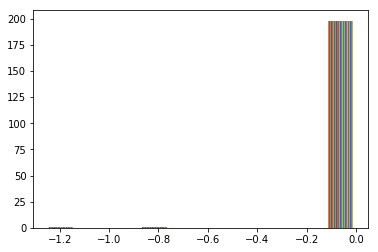

In [31]:
plt.hist(100*(gr_fx_y+dFx_dy)/dFx_dy); plt.show()

In [36]:
curl_l = dFx_dy - dFy_dx
print(dFx_dy[10,10], dFy_dx[10,10], curl_l[10,10])

3.962513085937502 -0.1929937500000003 4.155506835937502


In [38]:
curl_m = -gr_fy_x - gr_fx_y 
print(gr_fx_y[10,10], gr_fy_x[10,10], curl_m[10,10])

-3.962513085937502 -0.1929937500000003 4.155506835937502


In [34]:
print(theor_curl_mod[10,10])

4.1553966796875
